In [1]:
import os
seed = 0
os.environ['PYTHONHASSEED'] = str(seed)

In [2]:
import h5py
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import time
import random

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_regression

In [3]:
random.seed(seed)
np.random.seed(seed)

In [4]:
filename = '../data/turbofan_dataset/N-CMAPSS_DS02-006.h5'
output_path = 'DS02/exploration'

In [5]:
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [6]:
def load_dataset(filename, load_test_set=True):
    """ Reads a dataset from a given .h5 file and compose (in memory) the train and test data. 
    Args:
        filename(str): path to the .h5 file
    Returns:
        train_set(pd.DataFrame), test_set(pd.DataFrame)
    """
    with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        if load_test_set:
            W_test = np.array(hdf.get('W_test'))           # W
            X_s_test = np.array(hdf.get('X_s_test'))       # X_s
            X_v_test = np.array(hdf.get('X_v_test'))       # X_v
            T_test = np.array(hdf.get('T_test'))           # T
            Y_test = np.array(hdf.get('Y_test'))           # RUL  
            A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Column names
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        columns = []
        columns.append(list(np.array(A_var, dtype='U20')))
        columns.append(list(np.array(T_var, dtype='U20')))
        columns.append(list(np.array(X_s_var, dtype='U20')))
        columns.append(list(np.array(X_v_var, dtype='U20')))
        columns.append(list(np.array(W_var, dtype='U20')))
        columns.append(['RUL'])
        
        columns_list = []
        for columns_per_category in columns:
            columns_list += columns_per_category
        
    train_set = np.concatenate((A_dev, T_dev, X_s_dev, X_v_dev, W_dev, Y_dev), axis=1)
    if load_test_set:
        test_set = np.concatenate((A_test, T_test, X_s_test, X_v_test, W_test, Y_test), axis=1)
        return pd.DataFrame(data=train_set, columns=columns_list), pd.DataFrame(data=test_set, columns=columns_list), columns
    else:
        return pd.DataFrame(data=train_set, columns=columns_list), None, columns

In [7]:
start_time = time.process_time()  
train_set, test_set, columns = load_dataset(filename)
print("Operation time (sec): " , (time.process_time() - start_time))
print ("Train set shape: " + str(train_set.shape))
print ("Test set shape: " + str(test_set.shape))

columns_aux = columns[0] 
columns_health_params = columns[1] 
columns_sensor_measurements = columns[2] 

columns_virtual_sensors = columns[3]
columns_operating_conditions = columns[4] 
target_col = columns[5]

Operation time (sec):  9.46875
Train set shape: (5263447, 47)
Test set shape: (1253743, 47)


In [9]:
y_train = train_set['RUL']
x_train = train_set.drop(['RUL'], axis=1)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.9, random_state=seed)

In [11]:
auxiliary_columns = ['cycle', 'hs', 'Fc', 'unit']
x_train.drop(labels=[x for x in auxiliary_columns if x in x_train.columns], axis=1, inplace=True)

In [43]:
start_time = time.process_time()  
mi = mutual_info_regression(x_train, y_train, random_state=seed)
print("Operation time (sec): " , (time.process_time() - start_time))

Operation time (sec):  546.921875


In [44]:
mi_series = pd.Series(mi, index=x_train.columns)
mi_series = mi_series.sort_values(ascending=False)
normalized_mi = (mi_series - mi_series.min()) / (mi_series.max() - mi_series.min())

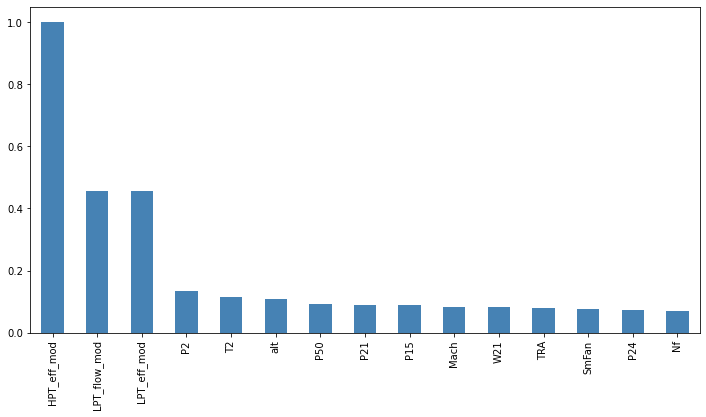

In [45]:
normalized_mi[:15].plot.bar(color='steelblue', figsize=(12, 6))
plt.savefig(os.path.join(output_path, "mutual_info.png"))

In [46]:
x_train.corrwith(y_train).sort_values(ascending=False)

HPT_eff_mod     0.751772
LPT_flow_mod    0.489825
LPT_eff_mod     0.473342
SmLPC           0.215121
SmHPC           0.105208
Nc              0.026882
W25             0.013903
W32             0.013903
W31             0.013903
W22             0.013901
W50             0.013282
W48             0.013246
Mach            0.013179
T30             0.012871
SmFan           0.012770
TRA             0.008674
Nf              0.008351
alt             0.007691
P40             0.005571
P30             0.005571
Ps30            0.004417
W21            -0.001102
P45            -0.003166
P21            -0.003623
P15            -0.003623
T2             -0.004511
P2             -0.004756
P24            -0.005246
P50            -0.005671
T24            -0.007947
Wf             -0.017543
T40            -0.050204
T48            -0.072477
phi            -0.091470
T50            -0.123531
fan_eff_mod          NaN
fan_flow_mod         NaN
LPC_eff_mod          NaN
LPC_flow_mod         NaN
HPC_eff_mod          NaN


In [8]:
def plot_kde(legend, variables, labels, size, units, df_data, df_aux, labelsize=17, output_file=None):
    plt.clf()
       
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs = gridspec.GridSpec(rows, cols)
    
    color_dic_unit = {'Unit 2': 'C0', 'Unit 5': 'C1', 'Unit 10': 'C2', 'Unit 16': 'C3', 'Unit 18': 'C4', 'Unit 6': 'C5',
                      'Unit 20': 'C6', 'Unit 11': 'C7', 'Unit 14': 'C8', 'Unit 15': 'C9'}
    
    fig = plt.figure(figsize=(size,max(size,rows*2)))       

    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for k, elem in enumerate(units):
            sns.kdeplot(df_data.loc[df_aux['unit'] == elem, variables[n]],
                        color=color_dic_unit[leg[k]], shade=True, gridsize=100)  
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
        
        ax.get_xaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))        
        plt.xlabel(labels[n], fontsize=labelsize)
        plt.ylabel('Density [-]', fontsize=labelsize)
    
    plt.legend(leg, fontsize=labelsize-4)
    plt.tight_layout()
    if output_file is not None:
        plt.savefig(output_file, dpi=300)    
    plt.show()
    plt.close()
    
def plot_df_color_per_unit(data, variables, labels, size=7, labelsize=17, option='Time', name=None):
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    color_dic_unit = {'Unit 2': 'C0', 'Unit 5': 'C1', 'Unit 10': 'C2', 'Unit 16': 'C3', 'Unit 18': 'C4', 'Unit 6': 'C5',
                      'Unit 20': 'C6', 'Unit 11': 'C7', 'Unit 14': 'C8', 'Unit 15': 'C9'}
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

In [9]:
full_dataset = pd.concat([train_set, test_set], ignore_index=True)
full_dataset.shape

(6517190, 47)

In [10]:
units = list(np.unique(full_dataset['unit']))
leg = ['Unit ' + str(int(u)) for u in units]
size = 15

<Figure size 432x288 with 0 Axes>

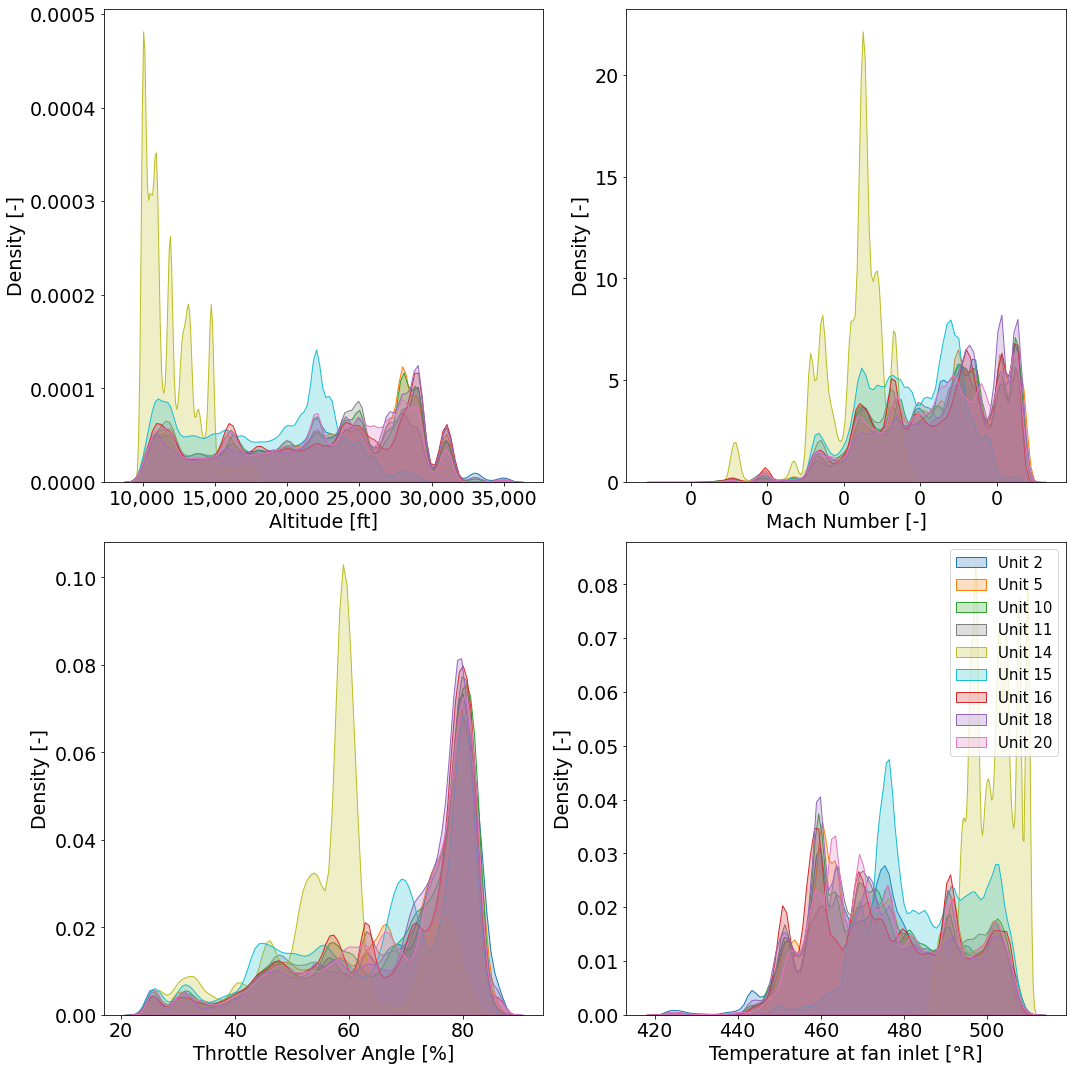

In [11]:
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']

output_file = os.path.join(output_path, 'kde_DS02_W.png')
plot_kde(leg, variables, labels, size, units, full_dataset, full_dataset[columns_aux],
         labelsize=19, output_file=output_file)

<Figure size 432x288 with 0 Axes>

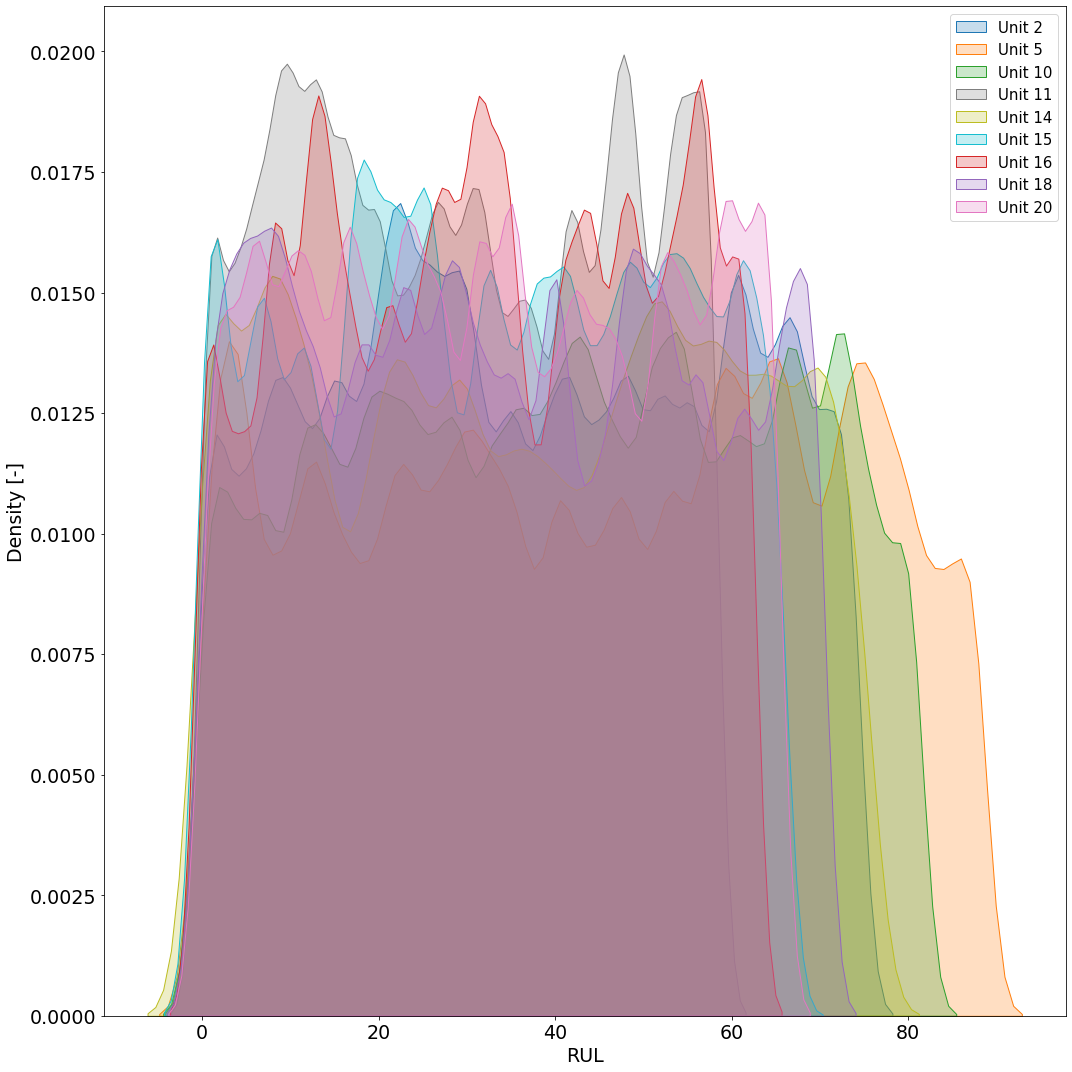

In [12]:
variables = ['RUL']
labels = ['RUL']

output_file = os.path.join(output_path, 'kde_DS02_RUL.png')
plot_kde(leg, variables, labels, size, units, full_dataset, full_dataset[columns_aux],
         labelsize=19, output_file=output_file)

('T24', 'T30')


<Figure size 432x288 with 0 Axes>

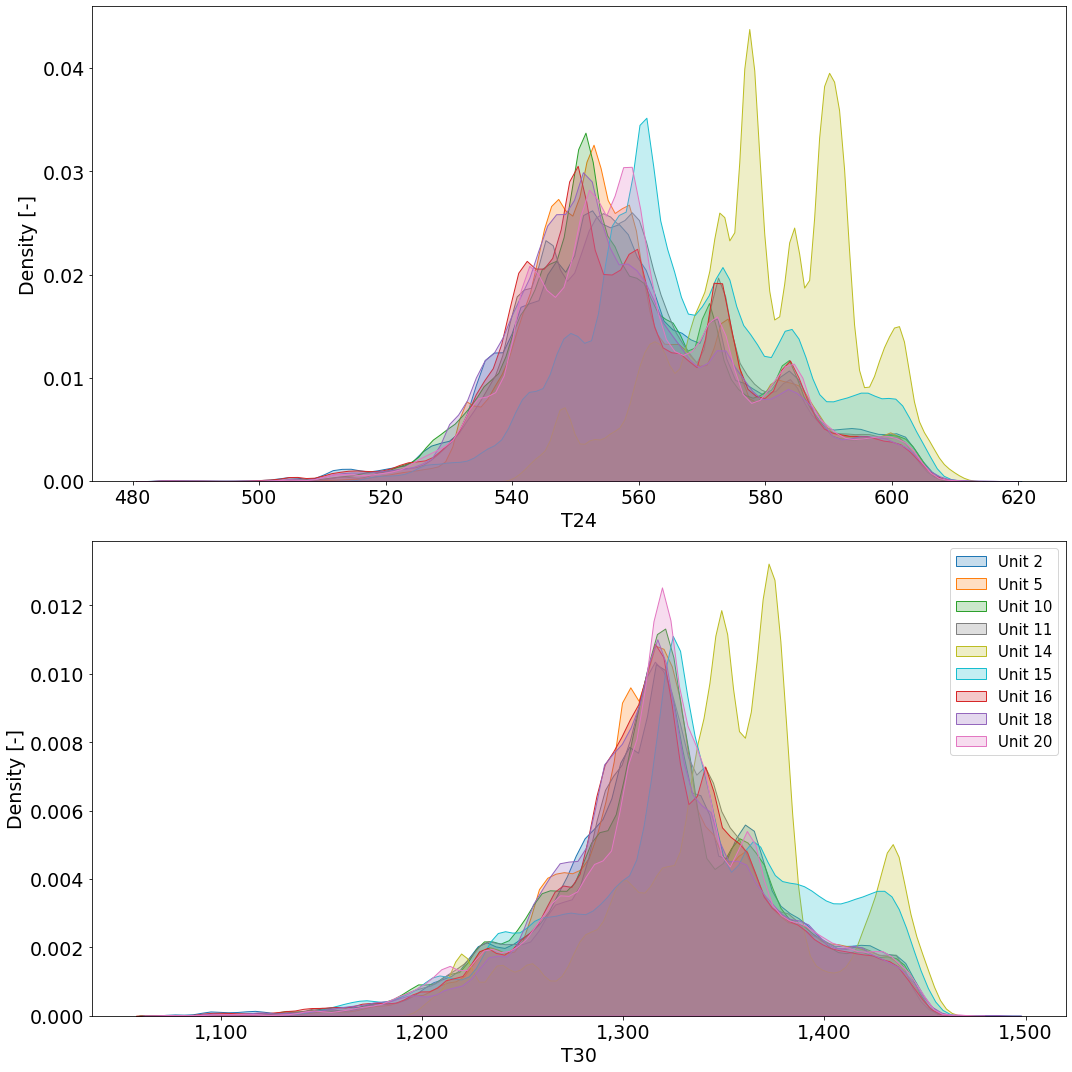

('T48', 'T50')


<Figure size 432x288 with 0 Axes>

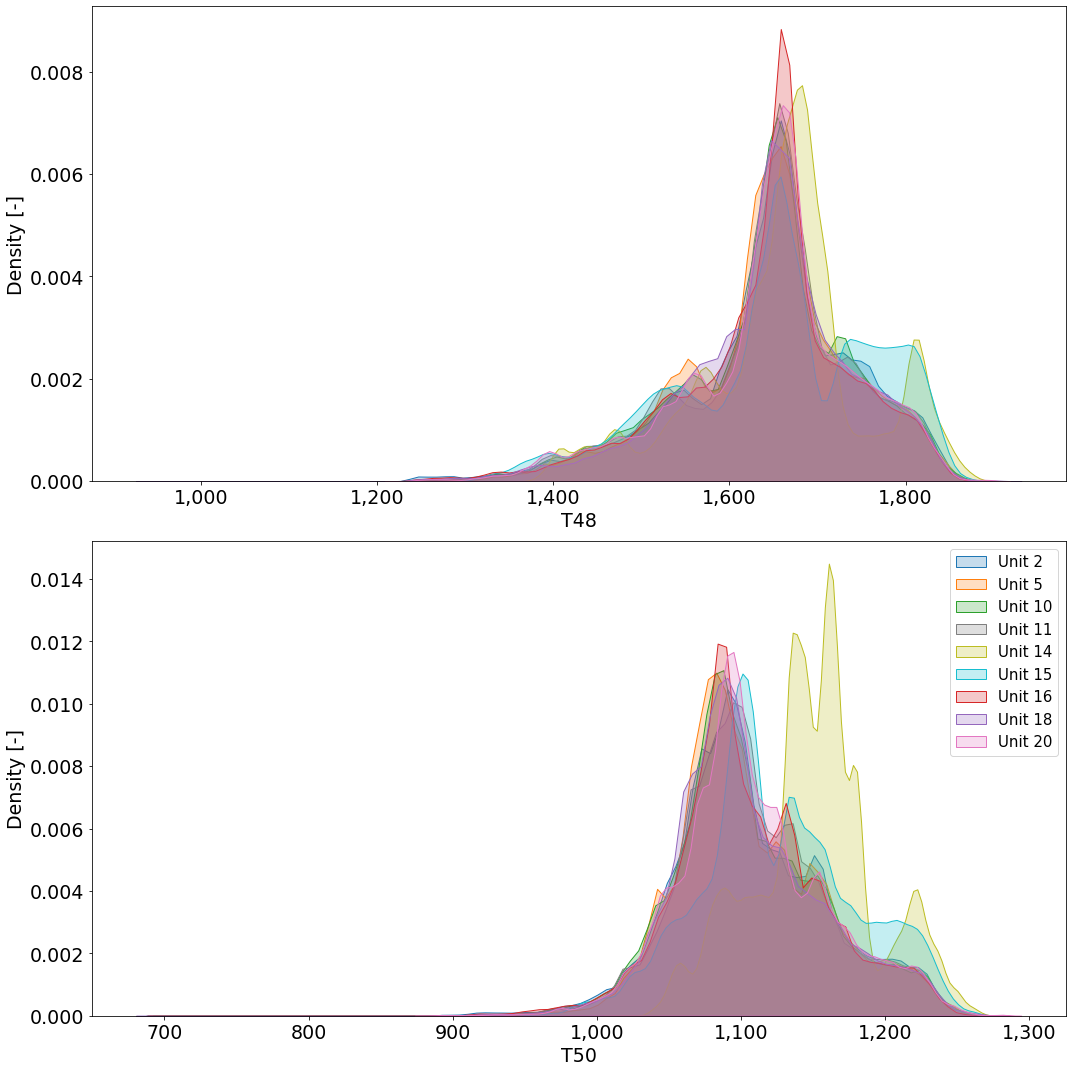

('P15', 'P2')


<Figure size 432x288 with 0 Axes>

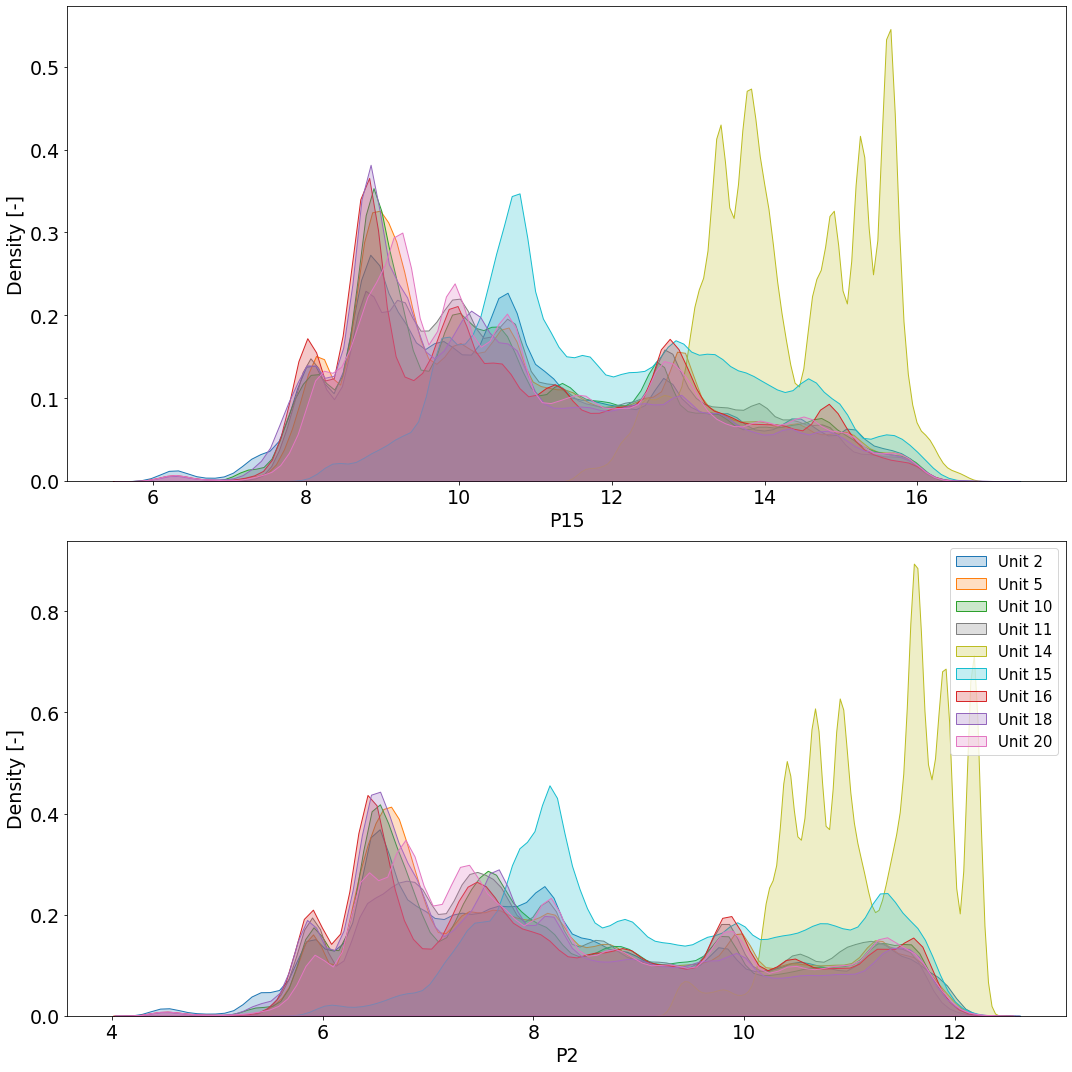

('P21', 'P24')


<Figure size 432x288 with 0 Axes>

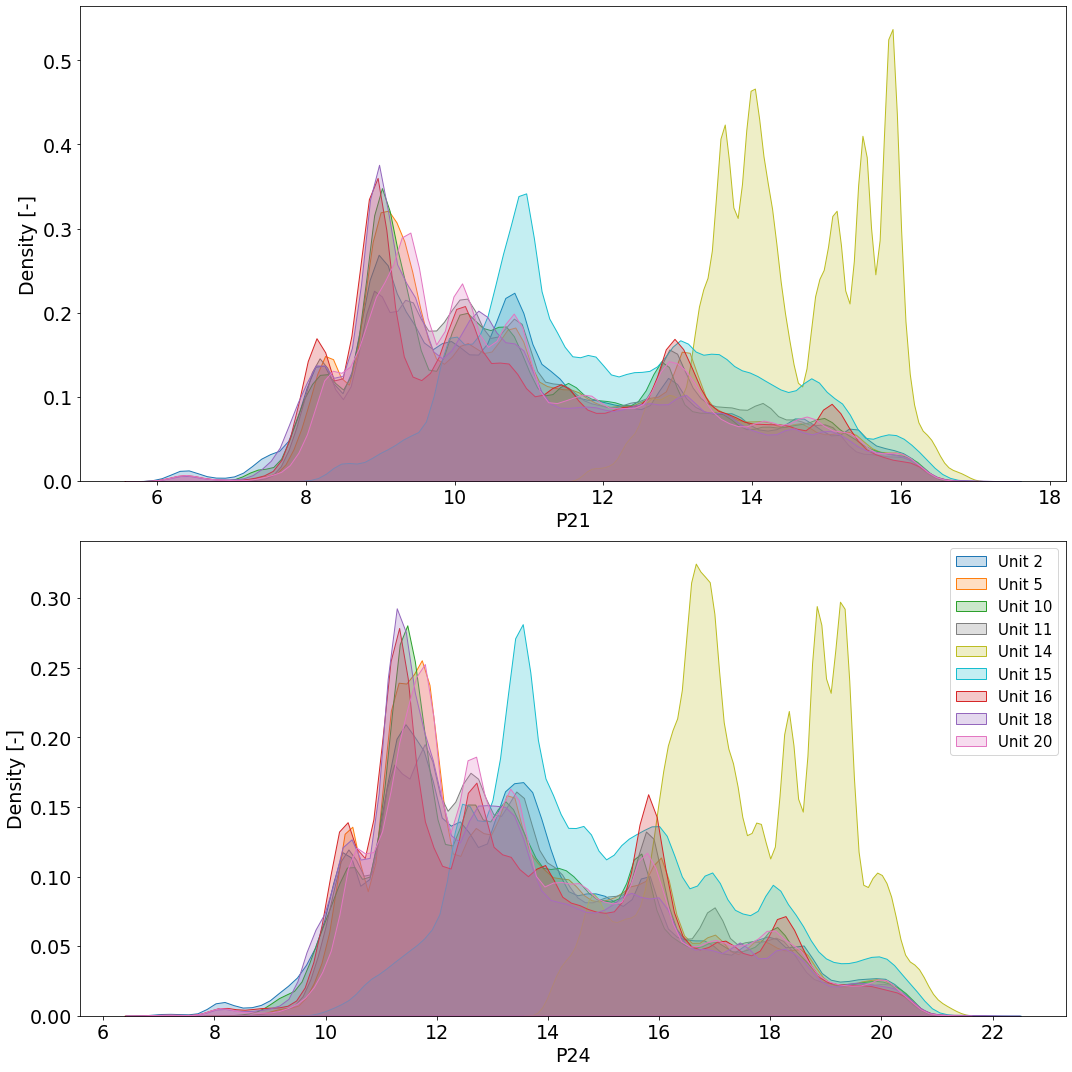

('Ps30', 'P40')


<Figure size 432x288 with 0 Axes>

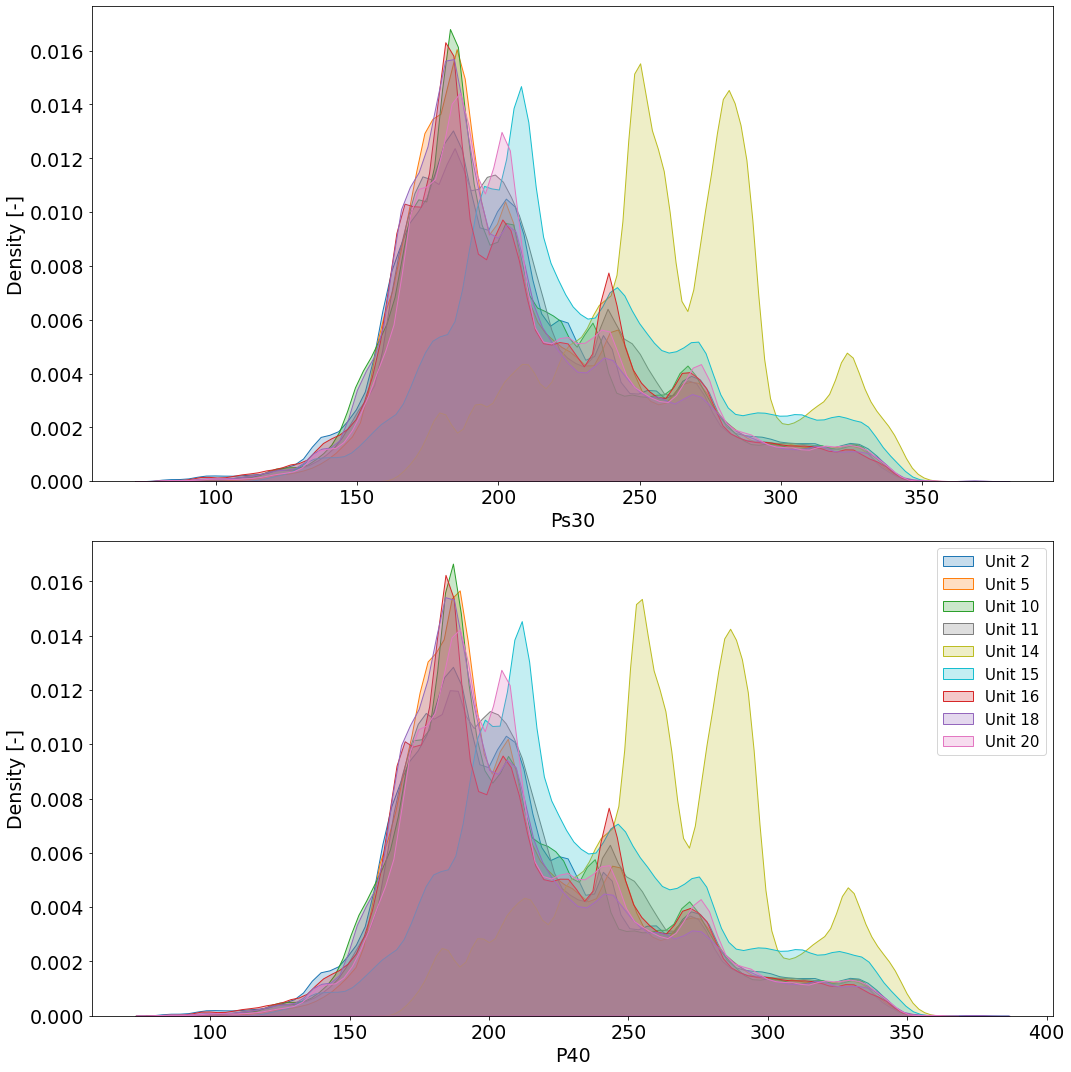

('P50', 'Nf')


<Figure size 432x288 with 0 Axes>

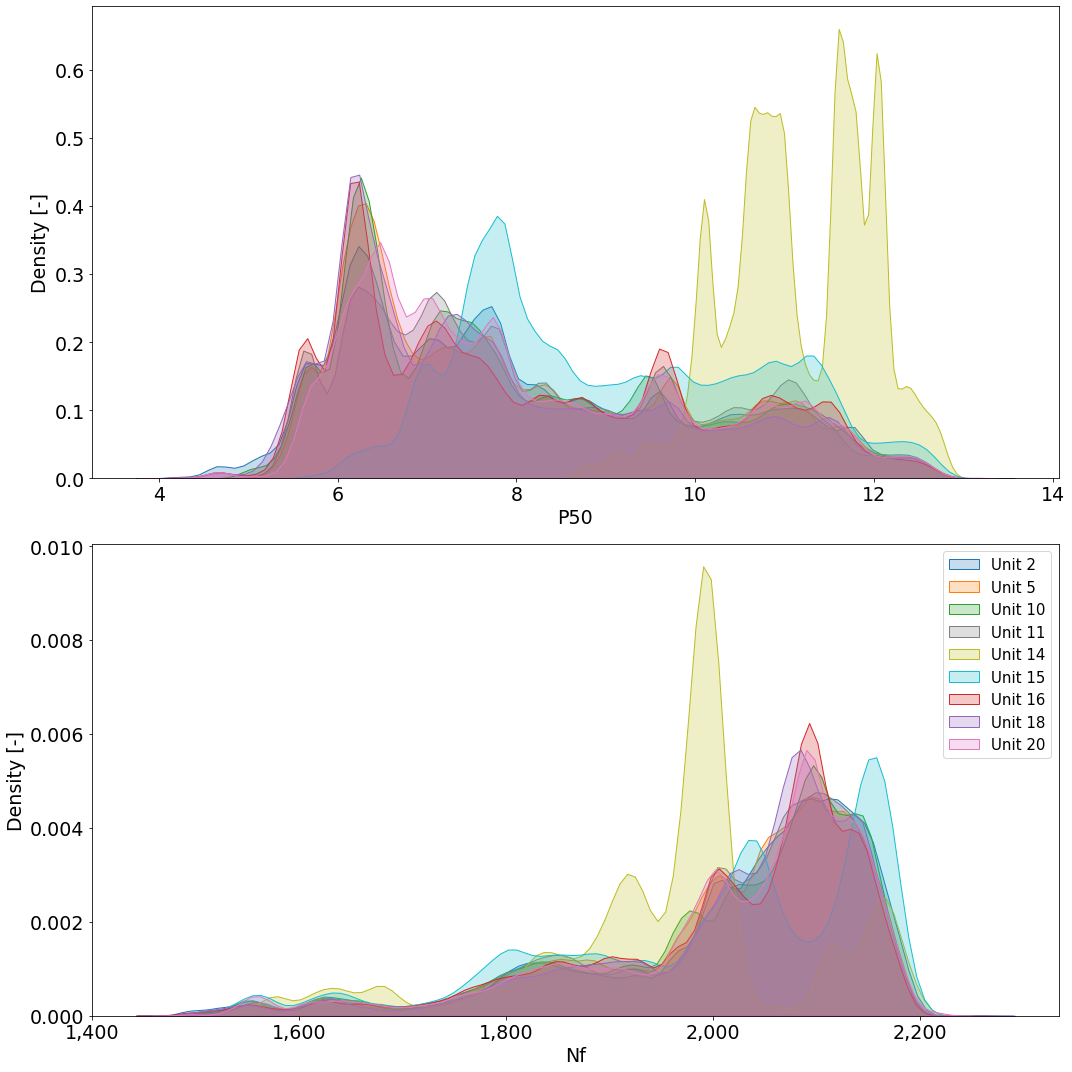

('Nc', 'Wf')


<Figure size 432x288 with 0 Axes>

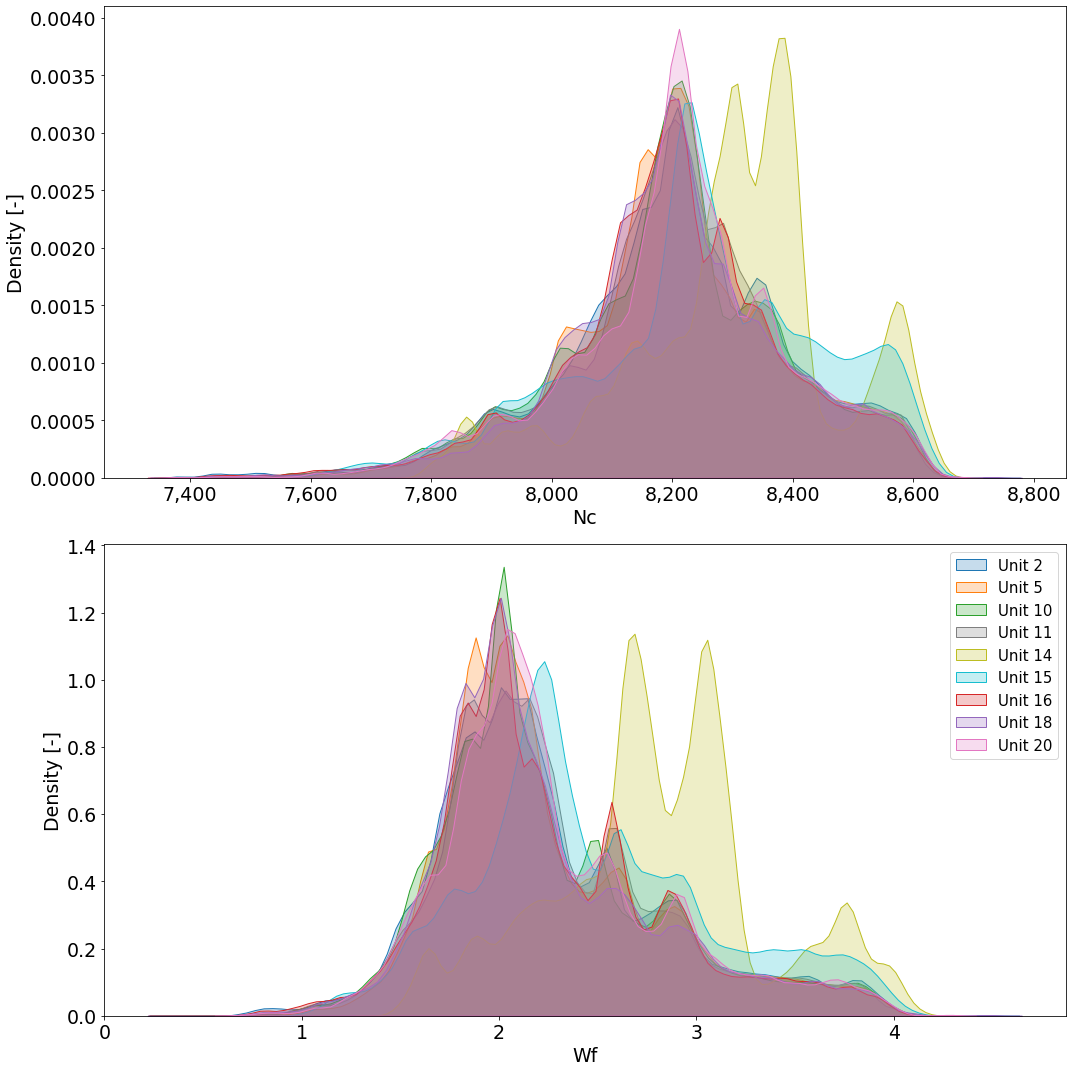

In [37]:
i = 0
for cols in zip(*[iter(columns_sensor_measurements)]*2):
    print(cols)
    output_file = os.path.join(output_path, f'kde_DS02_Xs_{i}.png')
    plot_kde(leg, cols, cols, size, units, full_dataset, full_dataset[columns_aux],
             labelsize=19, output_file=output_file)
    i += 1

('T40', 'P30')


<Figure size 432x288 with 0 Axes>

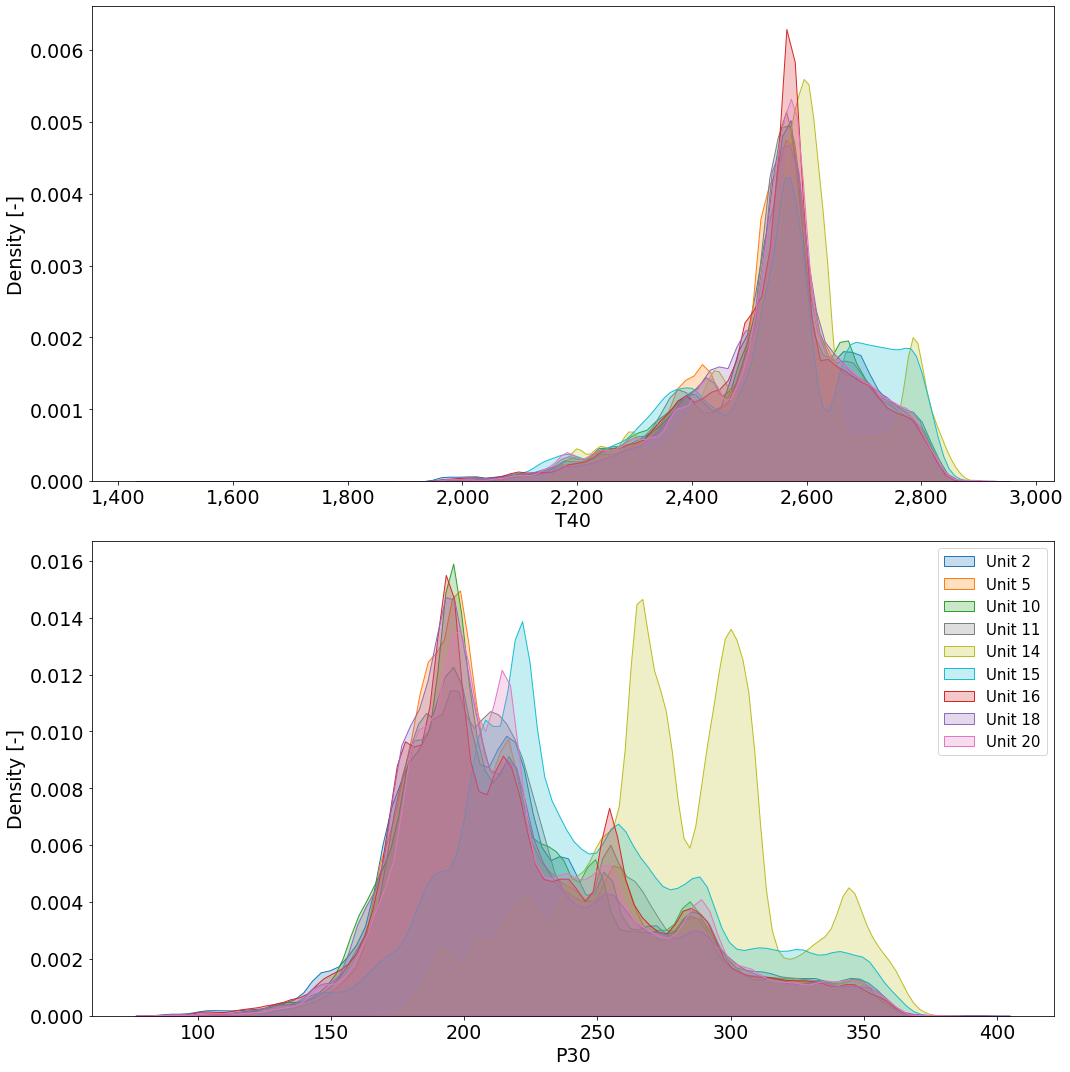

('P45', 'W21')


<Figure size 432x288 with 0 Axes>

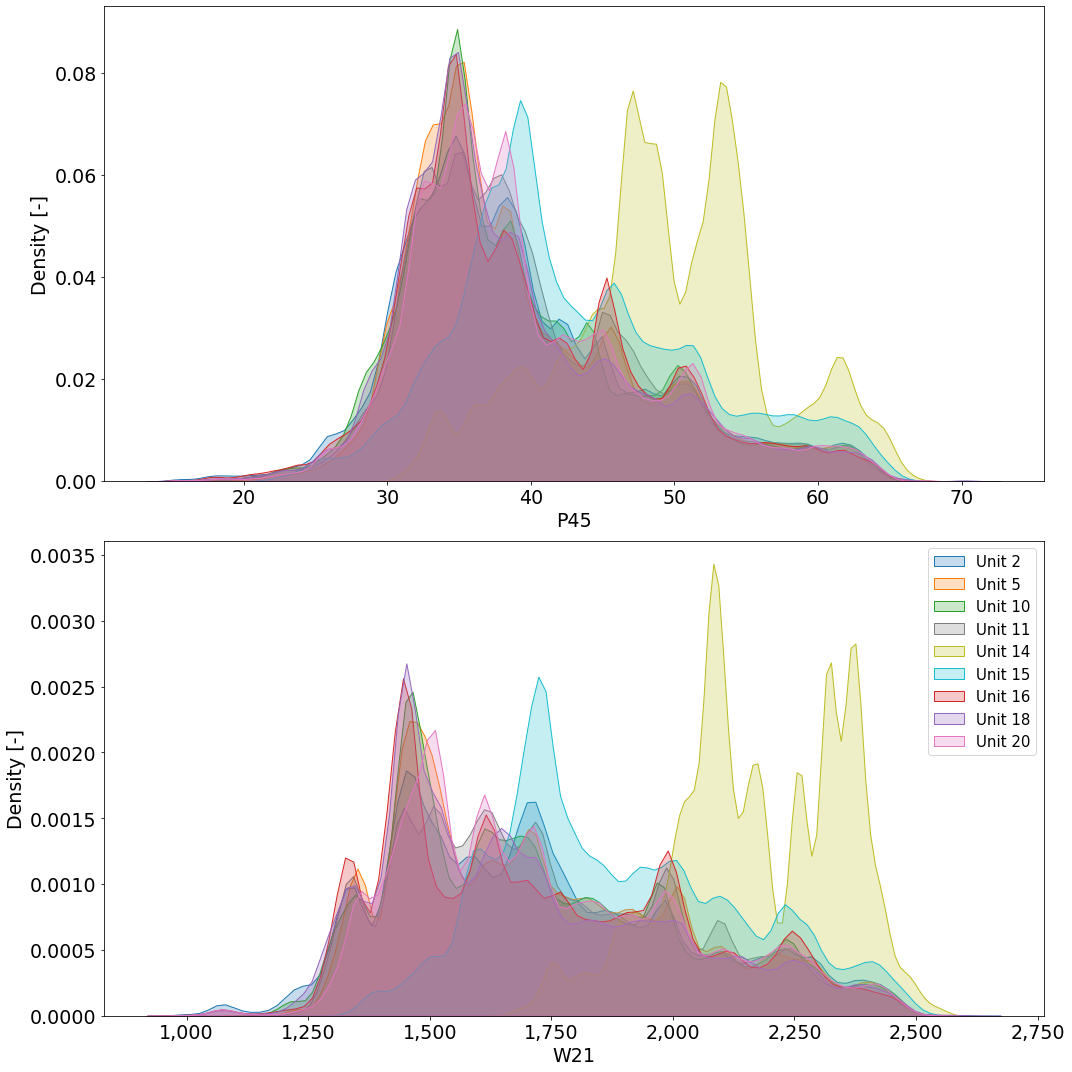

('W22', 'W25')


<Figure size 432x288 with 0 Axes>

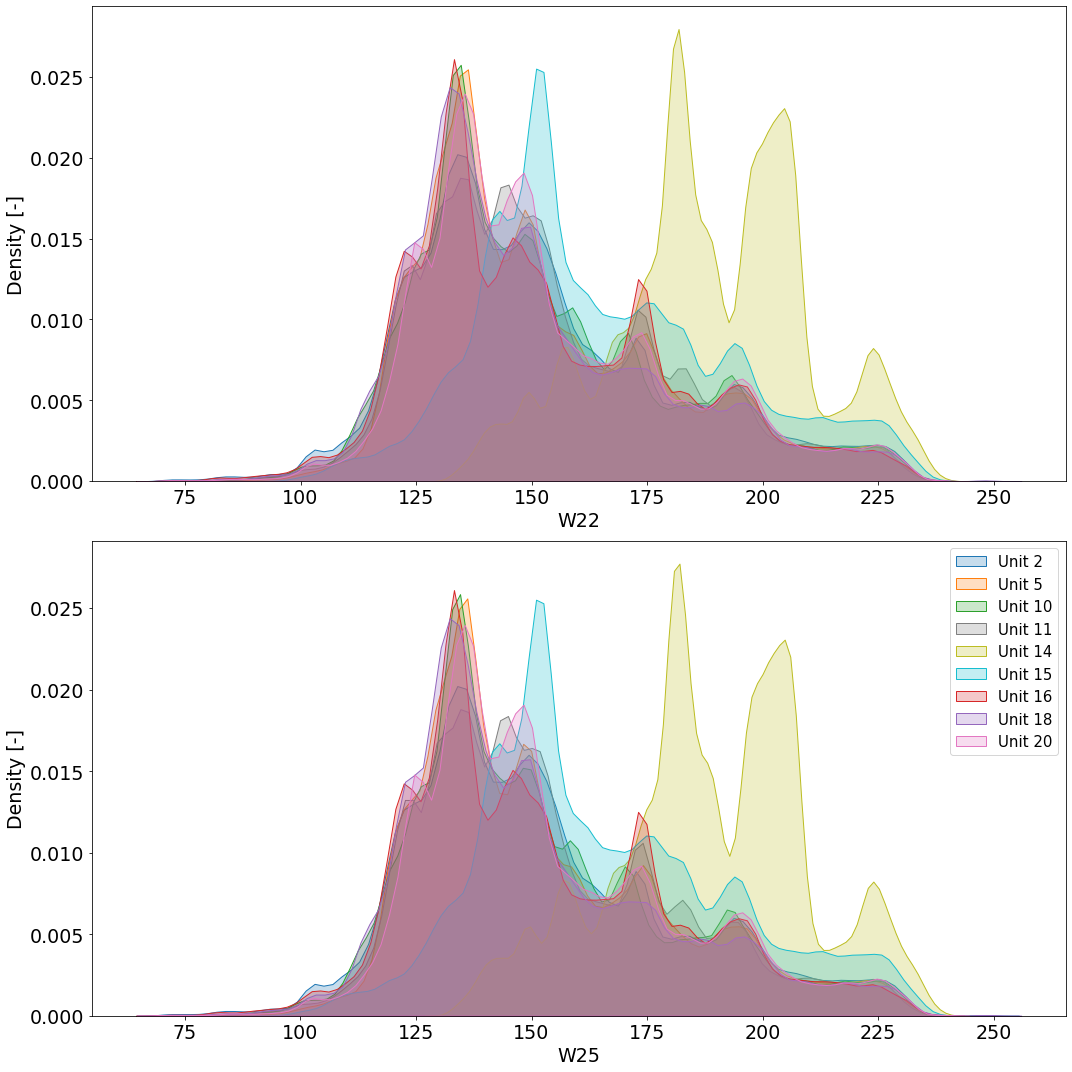

('W31', 'W32')


<Figure size 432x288 with 0 Axes>

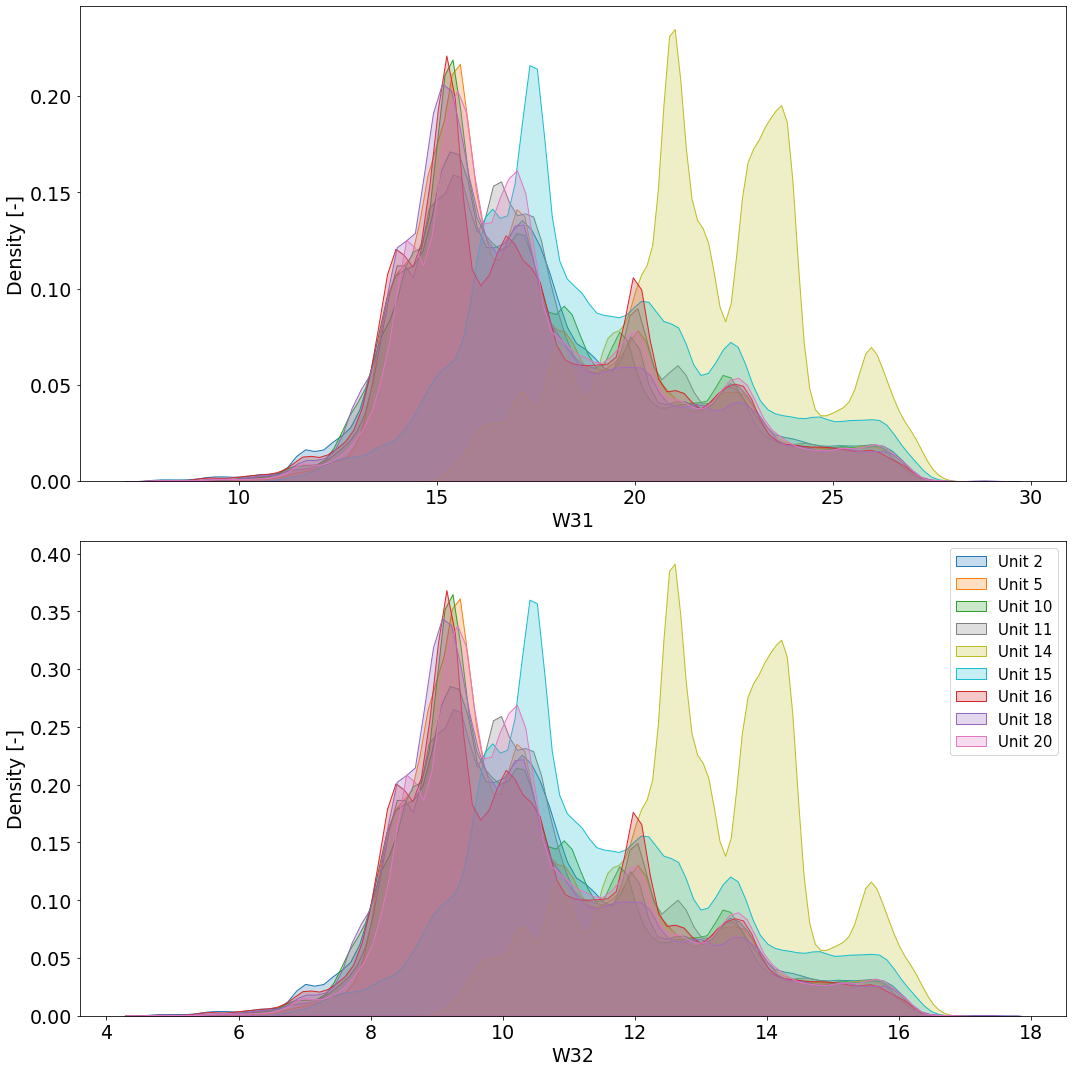

('W48', 'W50')


<Figure size 432x288 with 0 Axes>

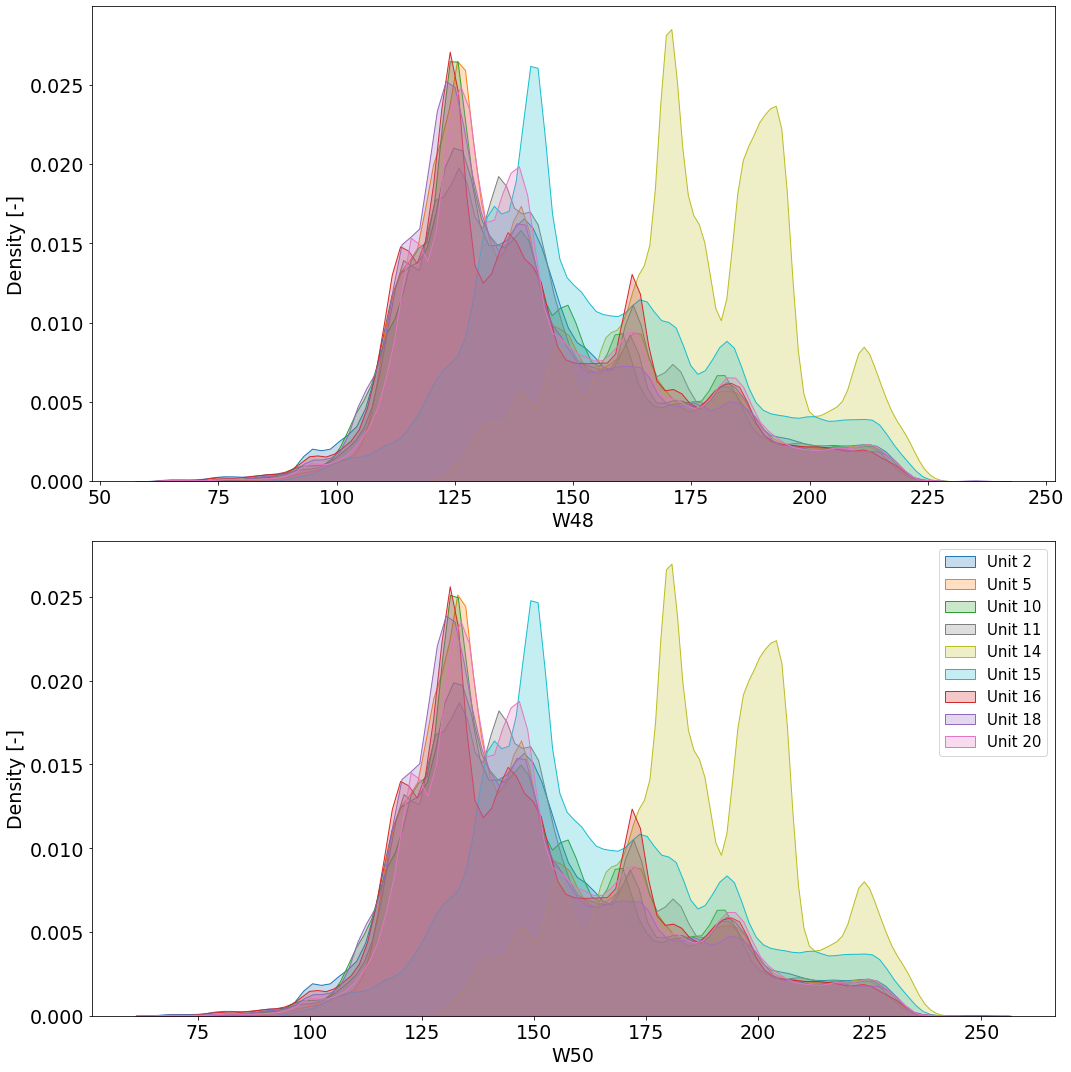

('SmFan', 'SmLPC')


<Figure size 432x288 with 0 Axes>

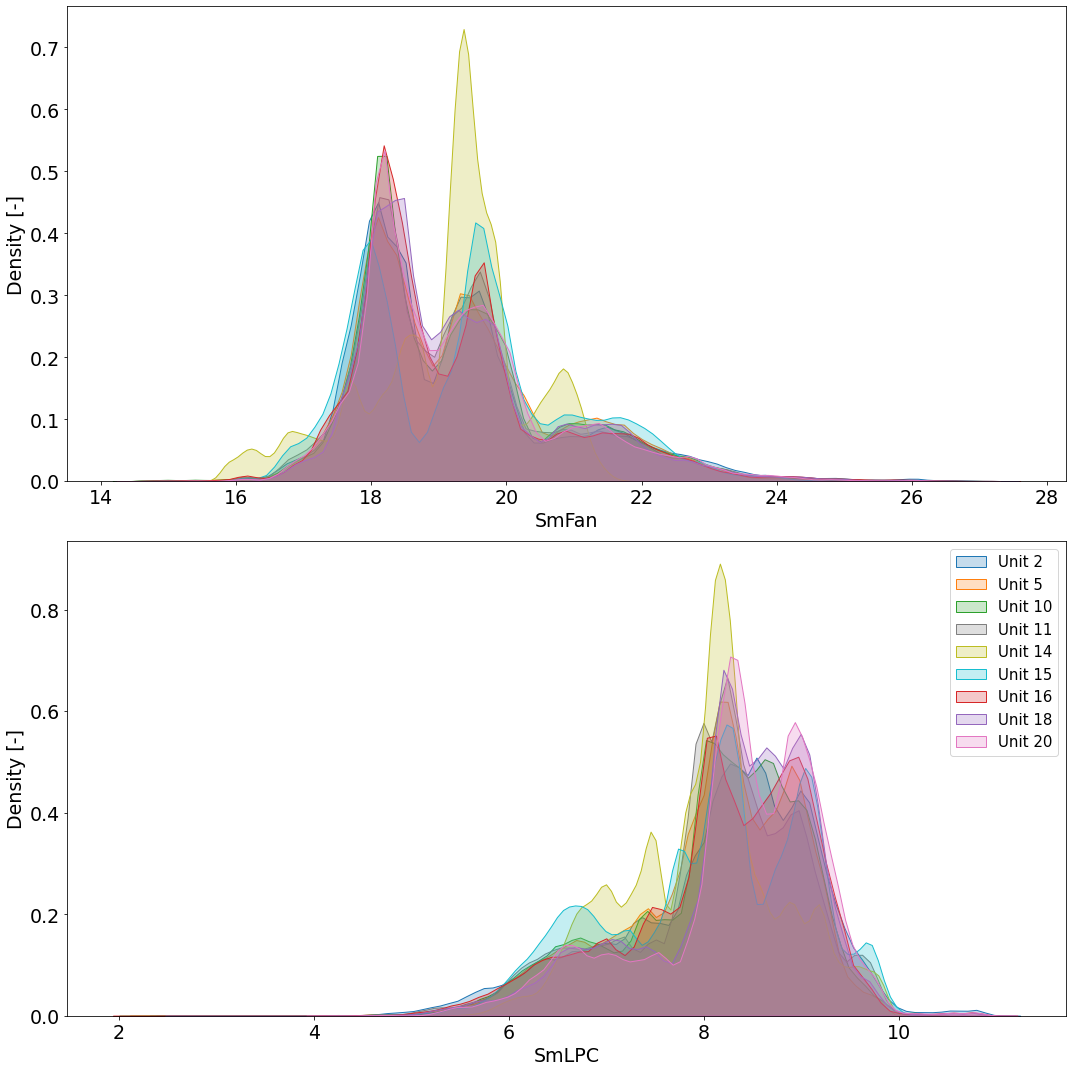

('SmHPC', 'phi')


<Figure size 432x288 with 0 Axes>

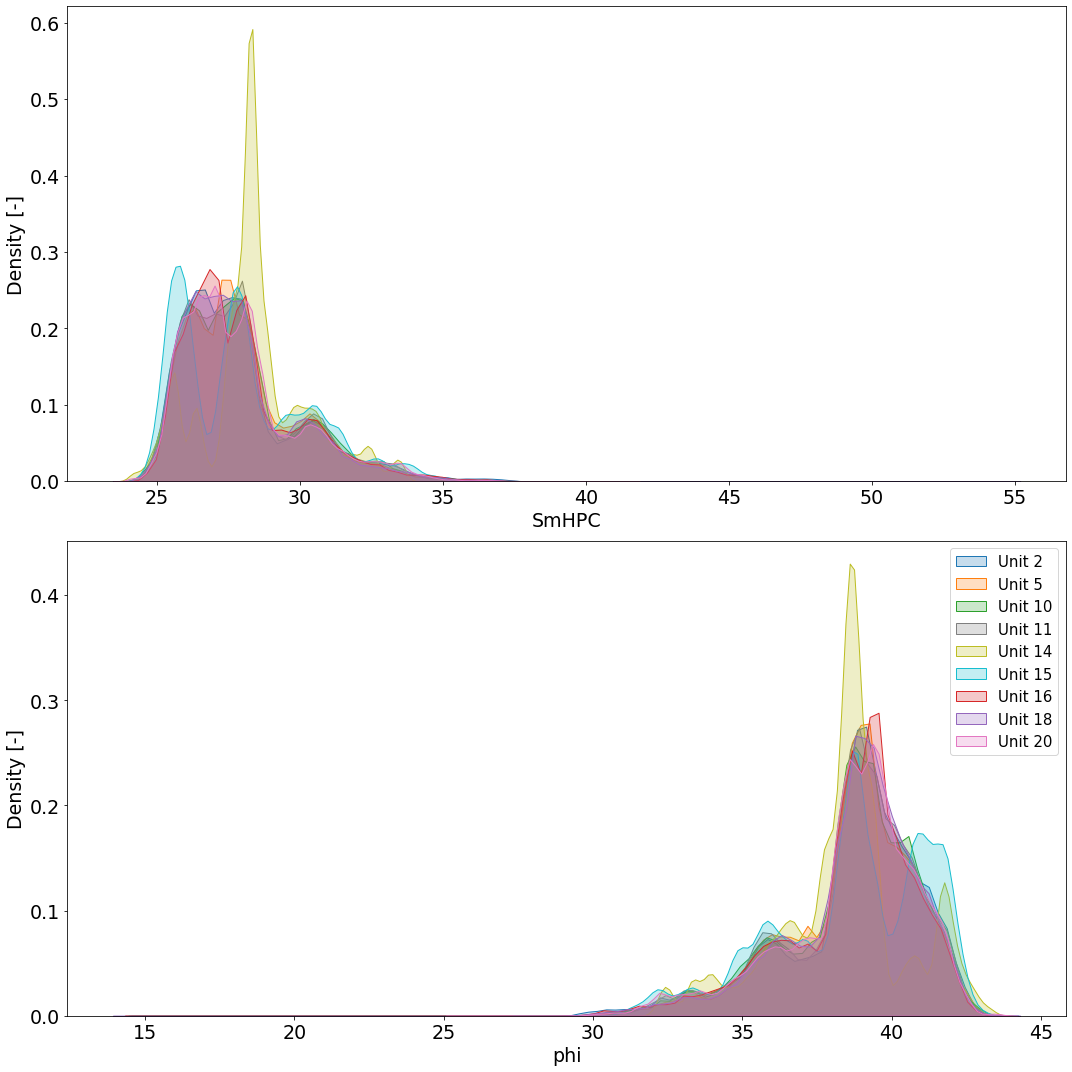

In [42]:
i = 0
for cols in zip(*[iter(columns_virtual_sensors)]*2):
    print(cols)
    output_file = os.path.join(output_path, f'kde_DS02_Xv_{i}.png')
    plot_kde(leg, cols, cols, size, units, full_dataset, full_dataset[columns_aux],
             labelsize=19, output_file=output_file)
    i += 1

<Figure size 432x288 with 0 Axes>

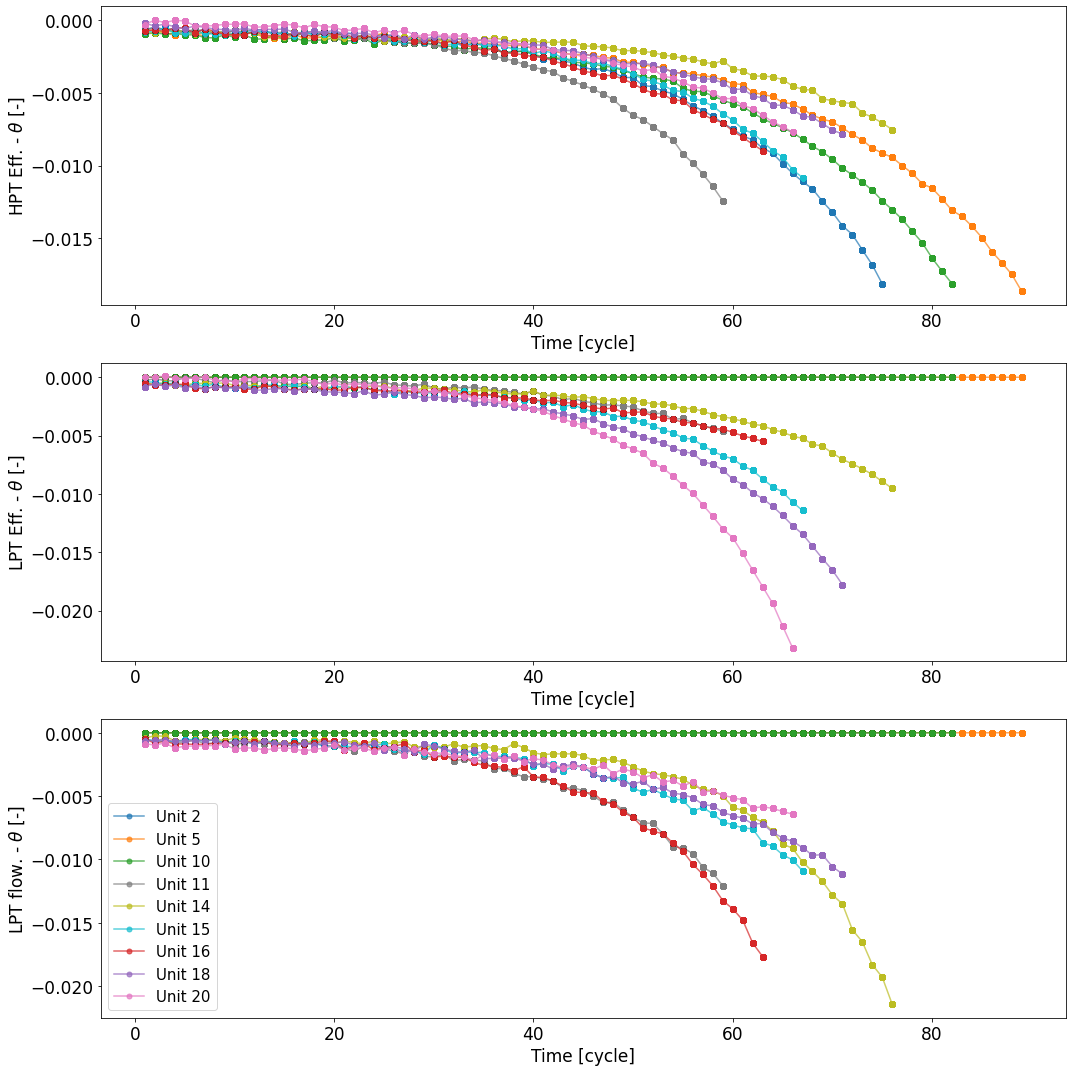

In [41]:
plot_df_color_per_unit(full_dataset, ['HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod'], 
                       [r'HPT Eff. - $\theta$ [-]', r'LPT Eff. - $\theta$ [-]', r'LPT flow. - $\theta$ [-]'], 
                       size=15,  
                       option='cycle',
                       name=os.path.join(output_path, f'DS02_health_params.png'))